In [1]:
# Developer Lab Notebook
# Experiment: Measure Inference Cost and GPU Usage

In [16]:
%matplotlib inline
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
"""
7. The discussion section briefly mentions the model’s computational cost but lacks concrete details. 
Given that transformer-based models are known for their high resource requirements, it is important to 
report metrics such as average inference time per genome, GPU memory usage, and scalability. In addition, 
potential solutions like model compression or inference-time optimization could be discussed to make the 
tool more accessible for users with limited computational resources. (ok 5)
"""

'\n7. The discussion section briefly mentions the model’s computational cost but lacks concrete details. \nGiven that transformer-based models are known for their high resource requirements, it is important to \nreport metrics such as average inference time per genome, GPU memory usage, and scalability. In addition, \npotential solutions like model compression or inference-time optimization could be discussed to make the \ntool more accessible for users with limited computational resources. (ok 5)\n'

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from pathlib import Path

TIS Prediction: 100%|██████████| 490/490 [1:22:34<00:00, 10.11s/it]


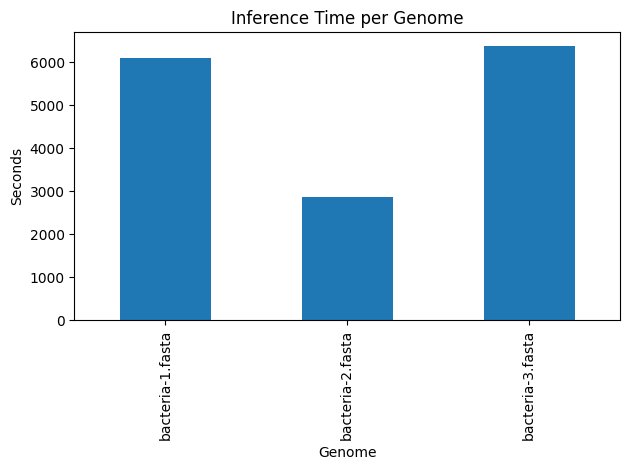

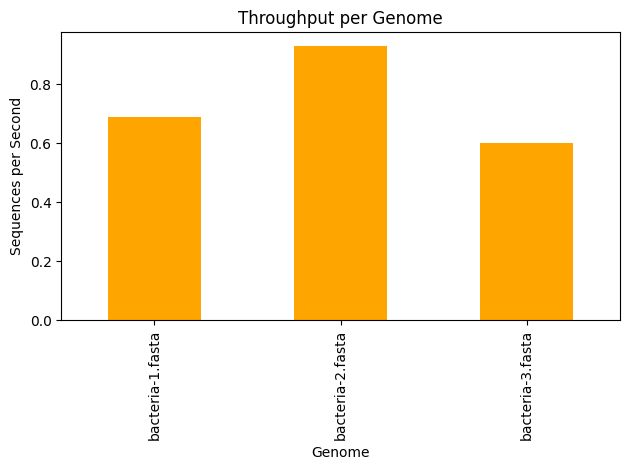

✅ Saved results to 'inference_benchmark_results.csv'


In [4]:
import torch
import pandas as pd
import numpy as np
import time
import gc
import os
from pathlib import Path
from api.core import AnnotatorPipeline
import matplotlib.pyplot as plt
from datetime import datetime
import logging

annotator = AnnotatorPipeline()
genome_files = [
    './data2-genome/bacteria-1.fasta',
    './data2-genome/bacteria-2.fasta',
    './data2-genome/bacteria-3.fasta'
]
results = []

# Get GPU info
def get_gpu_info():
    if torch.cuda.is_available():
        props = torch.cuda.get_device_properties(annotator.device)
        return props.name, round(props.total_memory / (1024**3), 2)
    return "CPU", 0

gpu_name, gpu_total_mem = get_gpu_info()

# Benchmark each genome
for genome_file in genome_files:
    torch.cuda.empty_cache()
    gc.collect()

    output_format = "CSV"
    uuid = Path(genome_file).stem + "-benchmark"
    tasks = {uuid: {"progress": 0, "status": "", "result": "", "exec_state": {}}}

    start_gpu_mem = torch.cuda.memory_allocated() / (1024**2) if torch.cuda.is_available() else 0
    start_time = time.time()

    result_path = annotator.pipeline(Path(genome_file), output_format, tasks, uuid, logging=logging)

    end_time = time.time()
    end_gpu_mem = torch.cuda.memory_allocated() / (1024**2) if torch.cuda.is_available() else 0

    total_time = round(end_time - start_time, 2)
    peak_mem = round(end_gpu_mem - start_gpu_mem, 2)
    file_size_kb = os.path.getsize(genome_file) / 1024

    try:
        df = pd.read_csv(result_path)
        n_preds = len(df)
        throughput = round(n_preds / total_time, 2) if total_time > 0 else 0
    except:
        n_preds = 0
        throughput = 0

    results.append({
        "Genome": Path(genome_file).name,
        "GPU Name": gpu_name,
        "GPU Total Memory (GB)": gpu_total_mem,
        "Batch Size": annotator.batch_size,
        "File Size (KB)": round(file_size_kb, 2),
        "Inference Time (s)": total_time,
        "Peak GPU Memory (MB)": peak_mem,
        "Number of Predictions": n_preds,
        "Throughput (seqs/sec)": throughput,
        "Output Path": str(result_path)
    })

# Save and visualize results
df_results = pd.DataFrame(results)
df_results.to_csv(f"inference_performance_benchmarck-{gpu_name}.csv", index=False)

# Plot
df_results.plot.bar(x="Genome", y="Inference Time (s)", title="Inference Time per Genome", legend=False)
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

df_results.plot.bar(x="Genome", y="Throughput (seqs/sec)", title="Throughput per Genome", color="orange", legend=False)
plt.ylabel("Sequences per Second")
plt.tight_layout()
plt.show()

print("✅ Saved results to 'inference_benchmark_results.csv'")

In [41]:
### We ran those analysis on other gpu ùmachine and bring result back here for comparison.

In [42]:
# CSV paths (update if needed)
files = [
    "inference_performance_benchmarck-NVIDIA A100-SXM4 80GB.csv",
    "inference_performance_benchmarck-NVIDIA RTX A5000 22GB.csv",
    "inference_performance_benchmarck-NVIDIA RTX A2000 12GB.csv"
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df.columns = df.columns.str.strip()
df["GPU Model"] = df["GPU Name"].str.extract(r'NVIDIA (.+)')

cols_to_drop = ["Peak GPU Memory (MB)", "Number of Predictions", "Throughput (seqs/sec)", "Output Path"]
df = df.drop(columns=cols_to_drop)

In [43]:
genome_dir = Path("data2-genome")
genome_sizes = {}

for fasta_file in genome_dir.glob("bacteria-*.fasta"):
    total_length = sum(len(record.seq) for record in SeqIO.parse(fasta_file, "fasta"))
    genome_sizes[fasta_file.name] = total_length

df["Genome Size (bp)"] = df["Genome"].map(genome_sizes)
df["Inference Time (min)"] = df["Inference Time (s)"] / 60

In [44]:
df

,Genome,GPU Name,GPU Total Memory (GB),Batch Size,File Size (KB),Inference Time (s),GPU Model,Genome Size (bp),Inference Time (min)
0,bacteria-1.fasta,NVIDIA A100-SXM4-80GB,79.15,5375,4597.63,1266.95,A100-SXM4-80GB,4641652,21.115833
1,bacteria-2.fasta,NVIDIA A100-SXM4-80GB,79.15,5375,2643.51,585.29,A100-SXM4-80GB,2668776,9.754833
2,bacteria-3.fasta,NVIDIA A100-SXM4-80GB,79.15,5375,4369.69,1303.66,A100-SXM4-80GB,4411532,21.727667
3,bacteria-1.fasta,NVIDIA RTX A5000-22GB,23.66,1556,4597.63,1984.66,RTX A5000-22GB,4641652,33.077667
4,bacteria-2.fasta,NVIDIA RTX A5000-22GB,23.66,1556,2643.51,935.75,RTX A5000-22GB,2668776,15.595833
5,bacteria-3.fasta,NVIDIA RTX A5000-22GB,23.66,1556,4369.69,2087.78,RTX A5000-22GB,4411532,34.796333
6,bacteria-1.fasta,NVIDIA RTX A2000-12GB,11.65,710,4597.63,6105.48,RTX A2000-12GB,4641652,101.758000
7,bacteria-2.fasta,NVIDIA RTX A2000-12GB,11.65,710,2643.51,2864.63,RTX A2000-12GB,2668776,47.743833
8,bacteria-3.fasta,NVIDIA RTX A2000-12GB,11.65,710,4369.69,6372.15,RTX A2000-12GB,4411532,106.202500


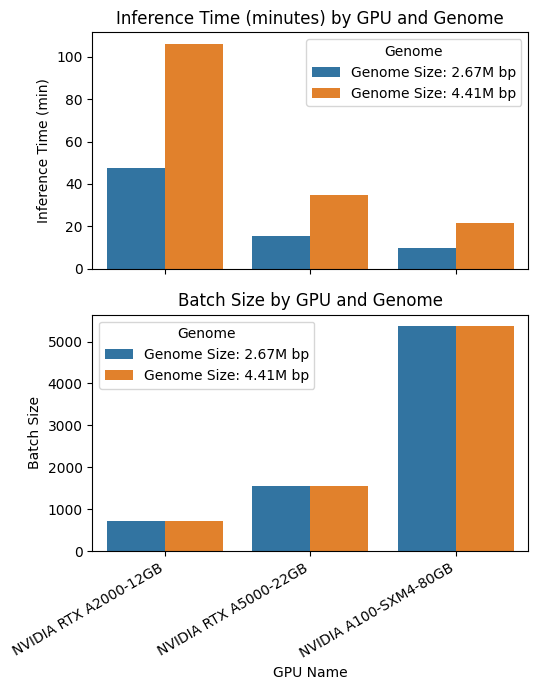

In [46]:
df_filtered = df[df['Genome'].isin(['bacteria-2.fasta', 'bacteria-3.fasta'])].copy()

# Map genome sizes for coloring
genome_color_map = {
    'bacteria-2.fasta': 'Genome Size: 2.67M bp',
    'bacteria-3.fasta': 'Genome Size: 4.41M bp'
}
df_filtered['Genome Label'] = df_filtered['Genome'].map(genome_color_map)

# Create GPU ordering based on total memory
gpu_order = df_filtered.groupby('GPU Name')['GPU Total Memory (GB)'].mean().sort_values().index
df_filtered['GPU Name'] = pd.Categorical(df_filtered['GPU Name'], categories=gpu_order, ordered=True)

# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(5.5, 7), sharex=True)

# Plot 1: Inference Time (minutes)
sns.barplot(
    data=df_filtered,
    x='GPU Name',
    y='Inference Time (min)',
    hue='Genome Label',
    ax=axes[0]
)
axes[0].set_title('Inference Time (minutes) by GPU and Genome')
axes[0].set_ylabel('Inference Time (min)')
axes[0].legend(title='Genome')

# Plot 2: Batch Size
sns.barplot(
    data=df_filtered,
    x='GPU Name',
    y='Batch Size',
    hue='Genome Label',
    ax=axes[1]
)
axes[1].set_title('Batch Size by GPU and Genome')
axes[1].set_ylabel('Batch Size')
axes[1].set_xlabel('GPU Name')
axes[1].legend(title='Genome')

# Rotate x-axis labels
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()